In [1]:
# Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

# to enable local imports
module_path = os.path.abspath('../../code')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
import json 
from pathlib import Path
try:
    try:
        json_path = (Path(os.getenv('LOCALAPPDATA'))/'Dropbox'/'info.json').resolve()
    except FileNotFoundError:
        json_path = (Path(os.getenv('APPDATA'))/'Dropbox'/'info.json').resolve()

    with open(str(json_path)) as f:
        j = json.load(f)

    personal_dbox_path = Path(j['personal']['path'])
    # Save the images directly into the dropbox where the overleaf document is stored
    IMAGES_PATH = os.path.join(str(personal_dbox_path), 'Apps', 'Overleaf', 'Masterthesis_Paper', 'images')

except Exception as e:
    IMAGES_PATH = "../images"
    print(e)
    
print("Saving images to: {}".format(IMAGES_PATH))
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')
    
from machine_learning_load_data import loadOnlineEEGdata

Using TensorFlow backend.


D:\Masterthesis\thesis_eeg\code
Saving images to: D:\Dropbox\Apps\Overleaf\Masterthesis_Paper\images


In [2]:
tf.__version__

'2.1.0'

In [3]:
keras.__version__

'2.2.4-tf'

In [4]:
# Load some online EEG Data
eegData, freqData, entropyData = loadOnlineEEGdata(dirPath='../../../EEG_Data/eeg_data_online', splitData=True)

X_train_eeg, y_train_eeg, X_test_eeg, y_test_eeg = eegData
X_train_freq, y_train_freq, X_test_freq, y_test_freq = freqData
X_train_entropy, y_train_entropy, X_test_entropy, y_test_entropy = entropyData

# reshape
X_train_freq = X_train_freq.reshape(X_train_freq.shape[0], X_train_freq.shape[2])
X_test_freq = X_test_freq.reshape(X_test_freq.shape[0], X_test_freq.shape[2])

X_train_entropy = X_train_entropy.reshape(X_train_entropy.shape[0], X_train_entropy.shape[2])
X_test_entropy = X_test_entropy.reshape(X_test_entropy.shape[0], X_test_entropy.shape[2])


##################
# experiment data
##################
eegData_exp, freqData_exp, entropyData_exp = loadOnlineEEGdata(dirPath='../../../EEG_Data/muse_data', splitData=True)

X_train_eeg_exp, y_train_eeg_exp, X_test_eeg_exp, y_test_eeg_exp = eegData_exp
X_train_freq_exp, y_train_freq_exp, X_test_freq_exp, y_test_freq_exp = freqData_exp
X_train_entropy_exp, y_train_entropy_exp, X_test_entropy_exp, y_test_entropy_exp = entropyData_exp

# reshape
X_train_freq_exp = X_train_freq_exp.reshape(X_train_freq_exp.shape[0], X_train_freq_exp.shape[2])
X_test_freq_exp = X_test_freq_exp.reshape(X_test_freq_exp.shape[0], X_test_freq_exp.shape[2])

X_train_entropy_exp = X_train_entropy_exp.reshape(X_train_entropy_exp.shape[0], X_train_entropy_exp.shape[2])
X_test_entropy_exp = X_test_entropy_exp.reshape(X_test_entropy_exp.shape[0], X_test_entropy_exp.shape[2])

#targetLabelsDict_exp = loadTargetLabelsTxt(filePath='../../EEG_Data/muse_data/target_labels.txt')
#targetNames_exp = ['AWAKE ({})'.format(targetLabelsDict_exp['AWAKE']),
#               'FATIGUE ({})'.format(targetLabelsDict_exp['FATIGUE'])]


Loading Online EEG Data from ../../../EEG_Data/eeg_data_online ...
EEG Data Shape:
X train: (5024, 512, 40) --- y train: (5024,) #### X test: (2154, 512, 40) ---- y test: (2154,)
Freq Data Shape:
X train: (1008, 1, 1200) --- y train: (1008,) #### X test: (432, 1, 1200) ---- y test: (432,)
Entropy Data Shape:
X train: (5024, 1, 200) --- y train: (5024,) #### X test: (2154, 1, 200) ---- y test: (2154,)
Loading Online EEG Data from ../../../EEG_Data/muse_data ...
EEG Data Shape:
X train: (5393, 512, 4) --- y train: (5393,) #### X test: (2312, 512, 4) ---- y test: (2312,)
Freq Data Shape:
X train: (1084, 1, 120) --- y train: (1084,) #### X test: (465, 1, 120) ---- y test: (465,)
Entropy Data Shape:
X train: (5393, 1, 20) --- y train: (5393,) #### X test: (2312, 1, 20) ---- y test: (2312,)


In [5]:
def TrainEvaluateNet(x_train, y_train, x_test, y_test):

    #Convert data set to numpy array of type float32
    #x_train = np.asarray(x_train, np.float32)
    #y_train = np.asarray(y_train, np.float32)
    #x_test = np.asarray(x_test, np.float32)
    #y_test = np.asarray(y_test, np.float32)

    #Number of neurons
    neurons_num = int((2/3) * x_train.shape[2])

    #Initialize neural net
    #output of layer = keras.layers.Dense(number of neurons, activation function, name)(input of layer)
    inputs = keras.Input(shape=(x_train.shape[1], x_train.shape[2]), name='input_points')
    x = keras.layers.Dense(neurons_num, activation='relu', name='L1')(inputs)
    x = keras.layers.Dense(neurons_num, activation='relu', name='L2')(x)
    outputs = keras.layers.Dense(2, activation='softmax', name='output_point')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='fatigue_classifier')

    #Set optimizer, loss function and metrics to track
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #binary_crossentropy

    #Summary of the neural net
    #model.summary()
    
    #Train neural net
    model.fit(x_train, y_train, epochs=3)

    #Evaluate neural net
    score = model.evaluate(x_test, y_test, verbose=verbose)
    loss = score[0]
    accuracy = score[1]
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    return (model, loss, accuracy)


In [6]:
def trainEvaluateNet(x_train, y_train, x_test, y_test,batch_size=64, num_classes=2, epochs=5, verbose=0):

    #Settings
    neurons_num = int((2/3) * x_train.shape[2]) #Number of neurons

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    #Initialize neural net
    model = Sequential()
    model.add(Conv1D(32, kernel_size=10, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Conv1D(64, kernel_size=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(neurons_num, activation='relu'))
    model.add(Dense(neurons_num, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax', name='last_dense')) 

    model.summary()
    
    #Set optimizer, loss function and metrics to track
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
    #model.compile(loss=keras.losses.squared_hinge, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

    #Summary of the neural net
    #model.summary()
    
    #Train neural net
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=verbose,
              validation_data=(x_test, y_test))
    #         validation_split=0.2)

    #Evaluate neural net
    score = model.evaluate(x_test, y_test, verbose=verbose)
    loss = score[0]
    accuracy = score[1]
    print('Test loss: {}'.format(loss))
    print('Test accuracy: {}'.format(accuracy))
    return (model, loss, accuracy)

    #Predict best route
    return model

In [44]:
def trainEasyNet(x_train, y_train, x_test, y_test, batch_size=64, num_classes=2, epochs=5, verbose=0):
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    neurons_num = int((2/3) * x_train.shape[1]) #Number of neurons
    #eurons_num = neurons_num * 1
    
    # define the keras model
    model = Sequential()
    model.add(Dense(int(neurons_num*2), input_dim=x_train.shape[1], activation='relu', name="Input_Dense"))
    model.add(Dense(neurons_num, activation='relu', name="Dense_2"))
    #model.add(GlobalAveragePooling1D())
    model.add(Dense(int(neurons_num/2), activation='relu', name="Dense_3"))
    
    dropout_value = 0.2
    model.add(Dropout(dropout_value, name="Dropout_Layer"))
    model.add(Dense(num_classes, activation='softmax', name='Dense_4'))
    
    # compile the keras model
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
    
    # fit the keras model on the dataset
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    #print("History: {}".format(history))
    
    #Evaluate neural net
    score = model.evaluate(x_test, y_test, verbose=verbose, batch_size=batch_size)
    loss = score[0]
    accuracy = score[1]
    #print('Test loss: {}'.format(loss))
    #print('Test accuracy: {}'.format(accuracy))
    
    return (model, loss, accuracy, history)





In [37]:
# fit and evaluate a model
def train_lstm(x_train, y_train, x_test, y_test, batch_size=64, num_classes=2, epochs=5, verbose=0):
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    try:
        n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
    except IndexError: 
        # reshape that...
        x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
        n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

    
    
    #print("n_timesteps: {} - n_features: {} - n_outputs: {}".format(n_timesteps, n_features, n_outputs))
    model = Sequential()
    
    model.add(LSTM(100, input_shape=(n_timesteps,n_features), name="input_lstm"))
    model.add(Dropout(0.3, name="dropout_1"))
    model.add(Dense(100, activation='relu', name="dense_1"))
    model.add(Dense(200, activation='relu', name="dense_2"))
    model.add(Dense(50, activation='relu', name="dense_3"))
    model.add(Dense(n_outputs, activation='softmax', name="dense_4"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    #print("History: {}".format(history))
    
    #Evaluate neural net
    score = model.evaluate(x_test, y_test, verbose=verbose, batch_size=batch_size)
    loss = score[0]
    accuracy = score[1]
    #print('Test loss: {}'.format(loss))
    #print('Test accuracy: {}'.format(accuracy))
    return (model, loss, accuracy, history)

def train_cnn(x_train, y_train, x_test, y_test,batch_size=64, num_classes=2, epochs=5, verbose=0):


    #Settings
    neurons_num = int((2/3) * x_train.shape[1]) #Number of neurons

    if len(x_train.shape) < 3:
        x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
        x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    #Initialize neural net
    model = Sequential()
    model.add(Conv1D(40, kernel_size=2, padding='same', name="conv1d_input", activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Conv1D(40, kernel_size=4, padding='same', name="conv1d_1", activation='relu'))
    model.add(MaxPooling1D(pool_size=2, name="max_pooling_1d"))
    model.add(Dropout(0.25, name="dropout_1"))
    model.add(Flatten(name="flatten_1"))
    model.add(Dense(neurons_num, activation='relu', name="dense_1"))
    model.add(Dropout(0.5, name="dropout_2"))
    model.add(Dense(num_classes, activation='softmax', name="dense_2")) 

    #model.summary()
    
    #Set optimizer, loss function and metrics to track
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])

    #Summary of the neural net
    #model.summary()
    
    #Train neural net
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=verbose,
              validation_data=(x_test, y_test))
    #         validation_split=0.2)

    #Evaluate neural net
    score = model.evaluate(x_test, y_test, verbose=verbose)
    loss = score[0]
    accuracy = score[1]
    #print('Test loss: {}'.format(loss))
    #print('Test accuracy: {}'.format(accuracy))
    return (model, loss, accuracy, history)

    
    
    

In [8]:
def ApplyNet(input_data, model):
    prediction = model.predict([input_data]) 
    return prediction

In [9]:
def plot_metrcis(statistics_data, title:str, metric:str = 'accuarcy'):
    
    # Define labels, positions, bar heights and error bar heights
    x_pos = np.arange(len(statistics_data.keys()))
    
    # Define labels, positions, bar heights and error bar heights
    model_names = statistics_data.keys()
    
    plot_data_dict = {}

    for model in statsDict.keys():
        for data_source_key in statsDict[model].keys():
            try:
                plot_data_dict[data_source_key].append(statsDict[model][data_source_key][metric])
            except KeyError:
                plot_data_dict[data_source_key] = []
                plot_data_dict[data_source_key].append(statsDict[model][data_source_key][metric])
        
        # plot for each model the training history
        plot_training_history(statsDict, model)

        
    
    # create plot
    width = 0.2    
    fig, ax = plt.subplots(figsize=(12,5))
    
    counter = 0
    for label, data in plot_data_dict.items():
        plt.bar(x_pos + width*counter, data, width, label=label)
        counter += 1
    
    # draw horizontal dashed line
    plt.axhline(y=0.5, color='black', linestyle='dashed')
    
    ax.set_ylabel(metric)
    ax.set_xticks(x_pos + width)
    ax.set_xticklabels(model_names)
    ax.set_title(title)
    ax.yaxis.grid(True)
    
    
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.legend(loc='best')
    
    # Save the figure and show
    save_fig("{}_metrics".format(title.replace(" ", "_")))
    plt.show()
    
def plot_training_history(statsDict, model):

    fig, ax = plt.subplots(figsize=(15,5))
    
    title = "{} Training accuracy".format(model)
    ax.set_title(title)

    for data_source in statsDict[model]:
        ax.plot(statsDict[model][data_source]['history'].history['accuracy'], label=data_source)

    plt.legend(loc="lower right")
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.set(xlabel='Epoch', ylabel='Accuracy')
    save_fig(title.replace(" ", "_"))

Evaluating Simple Neural Network...
Model: "Simple Neural Network - Online frequency data"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Dense (Dense)          (None, 1600)              1921600   
_________________________________________________________________
Dense_2 (Dense)              (None, 800)               1280800   
_________________________________________________________________
Dense_3 (Dense)              (None, 400)               320400    
_________________________________________________________________
Dropout_Layer (Dropout)      (None, 400)               0         
_________________________________________________________________
Dense_4 (Dense)              (None, 2)                 802       
Total params: 3,523,602
Trainable params: 3,523,602
Non-trainable params: 0
_________________________________________________________________
Model: "Simple Neural Network - Online en

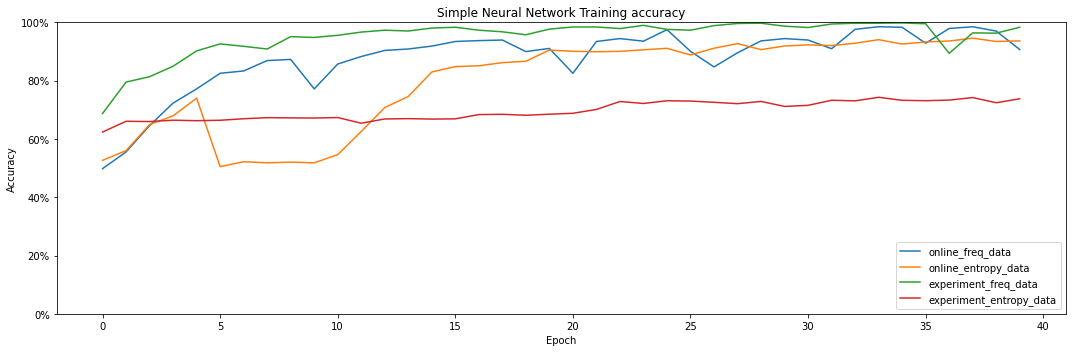

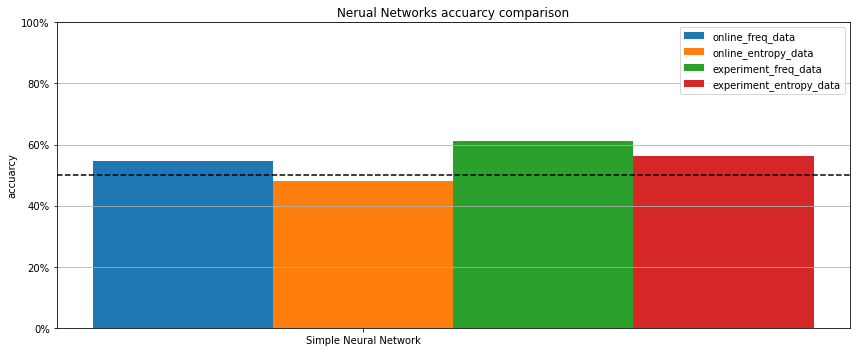

Batch size: 64
Epochs: 40


In [45]:
netFunctionList = []
netFunctionList.append(("Simple Neural Network", trainEasyNet))
#netFunctionList.append(("Simple CNN", train_cnn))
#netFunctionList.append(("Simple LSTM Net", train_lstm))
                    

epochs = 40
batch_size = 64
verbose = 0
num_classes = 2

statsDict = {}

for net_name, function in netFunctionList:
    print("Evaluating {}...".format(net_name))
    
    statsDict[net_name] = {}
    
    #print("Online Frequency Data")
    model, loss, accuarcy, history = function(X_train_freq, y_train_freq, X_test_freq, y_test_freq,
                                     epochs=epochs, batch_size=batch_size, verbose=verbose)
    statsDict[net_name]['online_freq_data'] = {"model" : model, "loss" : loss, "accuarcy" : accuarcy, "history": history}
    model.name="{} - Online frequency data".format(net_name)
    model.summary()
    plot_model(model, to_file=os.path.join(IMAGES_PATH,'{}_online_freq_data.png'.format(net_name)), show_shapes=True, show_layer_names=True)
    
    #print("Online Entropy Data")
    model, loss, accuarcy, history = function(X_train_entropy, y_train_entropy, X_test_entropy, y_test_entropy,
                                     epochs=epochs, batch_size=batch_size, verbose=verbose)
    statsDict[net_name]['online_entropy_data'] = {"model" : model, "loss" : loss, "accuarcy" : accuarcy, "history": history}
    model.name="{} - Online entropy data".format(net_name)
    model.summary()
    plot_model(model, to_file=os.path.join(IMAGES_PATH,'{}_online_entropy_data.png'.format(net_name)), show_shapes=True, show_layer_names=True)
    
    #print("Experiement Frequency Data")
    model, loss, accuarcy, history = function(X_train_freq_exp, y_train_freq_exp, X_test_freq_exp, y_test_freq_exp,
                                     epochs=epochs, batch_size=batch_size, verbose=verbose)
    statsDict[net_name]['experiment_freq_data'] = {"model" : model, "loss" : loss, "accuarcy" : accuarcy, "history": history}
    model.name="{} - Experiment frequency data".format(net_name)
    model.summary()
    plot_model(model, to_file=os.path.join(IMAGES_PATH,'{}_experiment_freq_data.png'.format(net_name)), show_shapes=True, show_layer_names=True)
    
    #print("Experiement Entropy Data")
    model, loss, accuarcy, history = function(X_train_entropy_exp, y_train_entropy_exp, X_test_entropy_exp, y_test_entropy_exp,
                                     epochs=epochs, batch_size=batch_size, verbose=verbose)
    statsDict[net_name]['experiment_entropy_data'] = {"model" : model, "loss" : loss, "accuarcy" : accuarcy, "history": history}
    model.name="{} - Experiment entropy data".format(net_name)
    model.summary()
    plot_model(model, to_file=os.path.join(IMAGES_PATH,'{}_experiment_entropy_data.png'.format(net_name)), show_shapes=True, show_layer_names=True)

print("Done")
plot_metrcis(statsDict, title="Nerual Networks accuarcy comparison")

print("Batch size: {}\nEpochs: {}".format(batch_size, epochs))